## Imports

In [14]:
import pandas as pd
import datetime as dtm
from IPython.display import Image
import logging

from strategy_execution import basket_creation_method
from helper import allocate_values
from strategy_builder import build_decision_tree_from_specs
from strategy_execution import basket_creation_method

import sigtech.framework as sig

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

env = sig.init()

2024-11-22 04:29:07,731 [45882] [sigtech.framework.config.settings.EnvironmentConfig] WARNING: You have already run init() to create an environment. This call will be ignored - to remove the previous environment use sig.de_init, restart the python kernel or pass repeat_mode='reinit'. To continue with the current configuration there are no actions needed.


## Data and global variables

In [15]:
# Define ETFs with complete names
etfs = {
    'TLT US EQUITY': sig.obj.get('TLT US EQUITY'),
    'TQQQ US EQUITY': sig.obj.get('TQQQ US EQUITY'),
    'SVXY US EQUITY': sig.obj.get('SVXY US EQUITY'),
    'VIXY US EQUITY': sig.obj.get('VIXY US EQUITY'),
    'QQQ UP EQUITY': sig.obj.get('QQQ UP EQUITY'),
    'SPY UP EQUITY': sig.obj.get('SPY UP EQUITY'),
    'BND UP EQUITY': sig.obj.get('BND UP EQUITY'),
    'BIL UP EQUITY': sig.obj.get('BIL UP EQUITY'),
    'GLD UP EQUITY': sig.obj.get('GLD UP EQUITY'),
}

# Retrieve ETF histories
etf_histories = {name: etf.history() for name, etf in etfs.items()}

# Define date range and initial cash
START_DATE = dtm.date(2024, 6, 2)
END_DATE = dtm.date(2024, 6, 30)
INITIAL_CASH = 1e6

# Example dates for decision tree evaluation
example_dates = [
    dtm.datetime(2024, 6, 30, 14, 50, 0),
    dtm.datetime(2024, 6, 27, 0, 0, 0),
    dtm.datetime(2024, 6, 26, 0, 0, 0),
    dtm.datetime(2024, 6, 25, 0, 0, 0),
    dtm.datetime(2024, 6, 24, 0, 0, 0),
    dtm.datetime(2024, 6, 21, 0, 0, 0),
    dtm.datetime(2024, 6, 20, 0, 0, 0),
    dtm.datetime(2024, 6, 18, 0, 0, 0),
    dtm.datetime(2024, 6, 17, 0, 0, 0),
    dtm.datetime(2024, 6, 14, 0, 0, 0),
    dtm.datetime(2024, 6, 13, 0, 0, 0),
    dtm.datetime(2024, 6, 12, 0, 0, 0),
    dtm.datetime(2024, 6, 11, 0, 0, 0),
    dtm.datetime(2024, 6, 10, 0, 0, 0),
    dtm.datetime(2024, 6, 7, 0, 0, 0),
    dtm.datetime(2024, 6, 6, 0, 0, 0),
    dtm.datetime(2024, 6, 5, 0, 0, 0),
    dtm.datetime(2024, 6, 4, 0, 0, 0),
    dtm.datetime(2024, 6, 3, 0, 0, 0)
]

## Define condition specifications

In [16]:
condition_specs = [
    {
        'node_name': 'decision_node_root',
        'indicator': 'RSI',
        'etf': 'QQQ UP EQUITY',
        'window': 20,
        'operator': '>',
        'threshold': 70,
        'true_branch': 'action_node1',
        'false_branch': 'decision_node_volatility'
    },
    {
        'node_name': 'decision_node_volatility',
        'indicator': 'Volatility',
        'etf': 'VIXY US EQUITY',
        'window': 11,
        'operator': '>',
        'threshold': 0.025,
        'true_branch': 'decision_node_cum_return',
        'false_branch': 'decision_node_rsi_lower'
    },
    {
        'node_name': 'decision_node_cum_return',
        'indicator': 'Cumulative Return',
        'etf': 'BND UP EQUITY',
        'window': 60,
        'operator': '>',
        'threshold': {
            'indicator': 'Cumulative Return',
            'etf1': 'BND UP EQUITY',
            'etf2': 'BIL UP EQUITY',
            'window': 60,
            'operator': '>'
        },
        'true_branch': 'action_node2a',
        'false_branch': 'action_node2b'
    },
    {
        'node_name': 'decision_node_rsi_lower',
        'indicator': 'RSI',
        'etf': 'QQQ UP EQUITY',
        'window': 31,
        'operator': '<',
        'threshold': 10,
        'true_branch': 'action_node3',
        'false_branch': 'action_node4'
    }
]

# Define action specifications
action_specs = {
    'action_node1': {'SPY UP EQUITY': 0.5, 'TLT US EQUITY': 0.5},
    'action_node2a': {'TQQQ US EQUITY': 1.0},
    'action_node2b': {'SPY UP EQUITY': 0.55, 'SVXY US EQUITY': 0.225, 'TLT US EQUITY': 0.225},
    'action_node3': {'TQQQ US EQUITY': 1.0},
    'action_node4': {'BIL UP EQUITY': 0.25, 'SPY UP EQUITY': 0.25, 'TLT US EQUITY': 0.25, 'GLD UP EQUITY': 0.25}
}

## Initialize the Dynamic Strategy

In [17]:
strat = sig.DynamicStrategy(
    currency='USD',
    start_date=START_DATE,
    end_date=END_DATE,
    trade_frequency='1BD',
    basket_creation_method=basket_creation_method,
    basket_creation_kwargs={
        'example_dates': example_dates,
        'etf_histories': etf_histories,
        'etfs': etfs,
        'condition_specs': condition_specs,
        'action_specs': action_specs
    },
    initial_cash=INITIAL_CASH,
)

# Build the strategy
strat.build(progress=True)


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[DecisionNode] Evaluating condition: RSI(QQQ UP EQUITY, 20) > 70 with threshold 70
[DecisionNode] Indicator Value for QQQ UP EQUITY: 58.8593954517936
[DecisionNode] Condition Met: False
[DecisionNode] Condition false. Traversing to False branch.
[DecisionNode] Evaluating condition: Volatility(VIXY US EQUITY, 11) > 0.025 with threshold 0.025
[DecisionNode] Indicator Value for VIXY US EQUITY: 0.0235520369951749
[DecisionNode] Condition Met: False
[DecisionNode] Condition false. Traversing to False branch.
[DecisionNode] Evaluating condition: RSI(QQQ UP EQUITY, 31) < 10 with threshold 10
[DecisionNode] Indicator Value for QQQ UP EQUITY: 57.71592996579445
[DecisionNode] Condition Met: False
[DecisionNode] Condition false. Traversing to False branch.
[ActionNode] Executing action: Allocate BIL UP EQUITY: 25.0%, SPY UP EQUITY: 25.0%, TLT US EQUITY: 25.0%, GLD UP EQUITY: 25.0%
[ActionNode] Allocations: {'BIL UP EQUITY': 2734.3322760581864, 'SPY UP EQUITY': 473.6642667677151, 'TLT US EQUITY': 

## Strategy Performance

In [18]:
strat.plot.performance()

## Visualize the Decision Tree

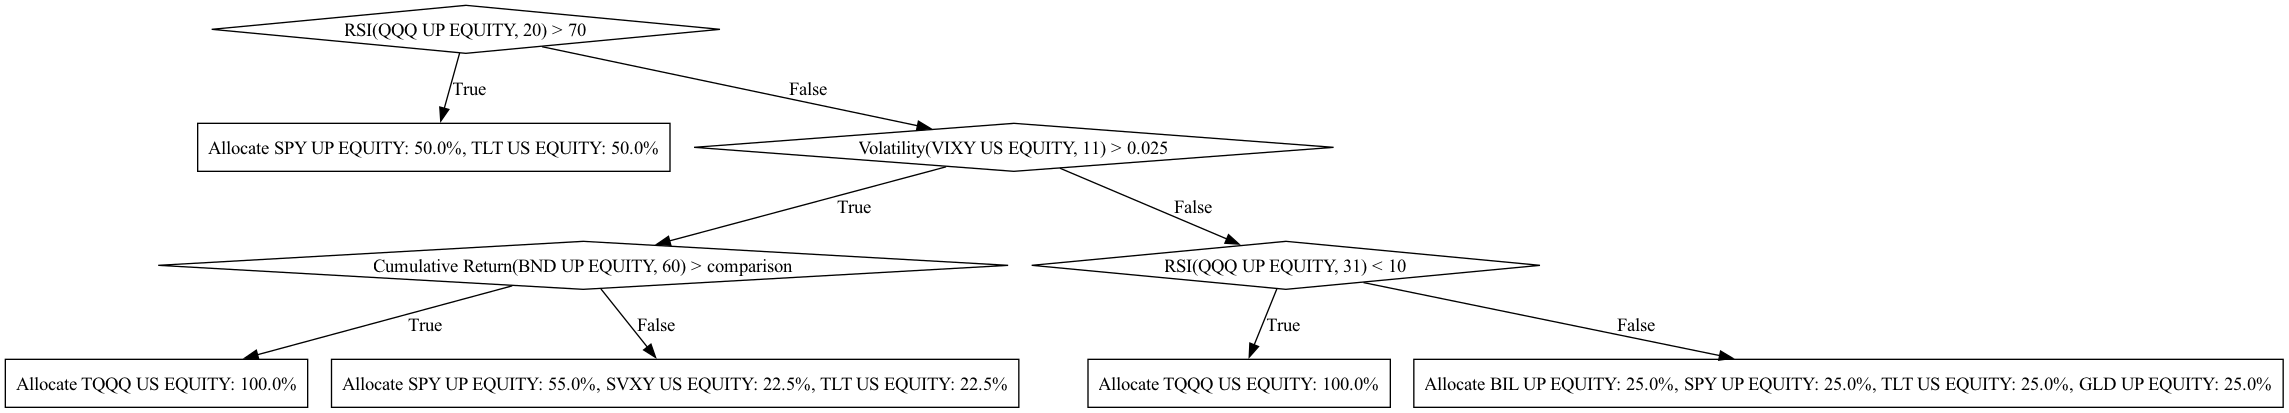

In [19]:
from strategy_builder import build_decision_tree_from_specs
from IPython.display import Image

# Build the decision tree
decision_tree = build_decision_tree_from_specs(condition_specs, action_specs)

# Plot and display the tree
dot = decision_tree.plot_tree(decision_tree.root)
dot.format = 'png'
dot.render('decision_tree', view=False)
Image(filename='decision_tree.png')
